In [3]:
import warnings
warnings.filterwarnings('ignore')

该解决方案的要点是：

1. 创建了一个由18个不同的、优化的模型组成的zoo。
2. 让所有的模型预测一个转换后的目标，即log1p(cost)，这样就可以使用平均误差平方作为损失函数。
3. 只使用特征的一个子集（特征选择）。
4. 将原始数据添加到训练数据中。
5. 通过对训练数据中的重复数据进行分组，大量减少训练时间。
6. 在一些模型中，将看似数字的 "商店面积 "视为分类的。
7. 最终提交的是18个单一模型的混合。

## Notebook的结构

这本笔记本并不以完整的EDA开始--已经看够了。只讨论两个在公开EDA中有些被忽视的主题： 重复的和分类的特征。在这个初步讨论之后，将有一个传统的部分（scikit-learn模型和梯度提升），然后是神经网络部分（Keras）。最后，将分析所产生的ensemble组合的多样性。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os, gc, pickle, datetime, lightgbm, math, catboost, xgboost, warnings
from scipy.cluster.hierarchy import dendrogram
from category_encoders.target_encoder import TargetEncoder
from colorama import Fore, Back, Style
plt.rcParams['font.family'] = 'Microsoft YaHei'

# import tensorflow as tf
# import tensorflow.keras.backend as K
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
# from tensorflow.keras.layers import Dense, Input, Concatenate
# from tensorflow.keras.utils import plot_model
# import keras_tuner

# from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
# from sklearn.model_selection import RepeatedKFold, KFold
# from sklearn.pipeline import make_pipeline, Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.decomposition import PCA
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, FunctionTransformer
# from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
# from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, LassoCV, LogisticRegression, SGDClassifier
# from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
# from sklearn.metrics import mean_squared_log_error, mean_squared_error
# from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
# from sklearn.inspection import PartialDependenceDisplay
# from sklearn.cluster import AgglomerativeClustering

np.set_printoptions(linewidth=150, edgeitems=5)

np.set_printoptions(linewidth=150, edgeitems=5)

用于设置打印数组的选项。

具体来说，set_printoptions() 函数允许你自定义打印数组时的一些行为，包括线宽和边缘项。

linewidth 参数用于设置打印数组时的行宽（line width），即每行最大字符数。默认情况下，行宽为75个字符。通过设置 linewidth 参数，你可以增加或减少行的宽度，以适应你的需要。在 np.set_printoptions(linewidth=150, edgeitems=5) 中，行宽被设置为150个字符。

edgeitems 参数用于设置打印数组时显示的边缘项（edge items）的数量。边缘项是数组中首尾元素之外的项。默认情况下，边缘项的数量为3个。通过设置 edgeitems 参数，你可以控制在打印数组时显示的边缘项的数量。在 np.set_printoptions(linewidth=150, edgeitems=5) 中，边缘项的数量被设置为5个。

In [4]:
result_list = []
train = pd.read_csv('input/playground-series-s3e11/train.csv', index_col='id')
test = pd.read_csv('input/playground-series-s3e11/test.csv', index_col='id')
original = pd.read_csv('input/media-campaign-cost-prediction/train_dataset.csv')

print(f"Length of train:          {len(train)}")
print(f"Length of test:           {len(test)}")
print(f"Length of original_train: {len(original)}")
print()

print('Sample data from train:')
train.tail(3)

Length of train:          360336
Length of test:           240224
Length of original_train: 51363

Sample data from train:


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
id,,,,,,,,,,,,,,,,
360333,10.74,3.0,0.0,0.0,2.0,11.3,1.0,0.0,35.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,11.04,3.0,1.0,0.0,3.0,10.2,0.0,1.0,14.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72
360335,5.30,2.0,2.0,0.0,2.0,10.8,0.0,0.0,21.0,33858.0,1.0,0.0,1.0,1.0,1.0,122.47


# 特征工程

不需要太多的特征工程:只需要对目标进行转换，这样就可以对RMSE而不是RMSLE进行优化，然后将两个几乎相同的特征`salad_bar`和`prepared_food`合并。

In [4]:
for df in [train, original]:
    df['log_cost'] = np.log1p(df['cost'])
target = 'log_cost'
    
for df in [train, test, original]:
    df['salad'] = (df['salad_bar'] + df['prepared_food']) / 2


# 特征选择

在整个笔记本中，用两个特征子集来工作：
- `most_important_features`是八个最重要的特征的列表。
- `relevant_features`是一个九元素的列表，其中还包含单位销售额(百万)。

事实证明，最好的模型只使用8个最重要的特征，但如果包括一些9个特征的模型，Ensemble就会得到改善。

In [5]:
# Selection of eight features
most_important_features = ['total_children', 'num_children_at_home',
                           'avg_cars_at home(approx).1', 'store_sqft',
                           'coffee_bar', 'video_store', 'salad', 
                           'florist']

# Selection of nine features
relevant_features = ['unit_sales(in millions)'] + most_important_features


# EDA第一部分： 重复和分组的技巧

在数据集中，并非所有的特征都是相关的，而且相关的特征只有很少的唯一值：

In [6]:
print("Unique values:")
for f in relevant_features:
    print(f"{f:26} {np.unique(train[f])}")

Unique values:
unit_sales(in millions)    [1. 2. 3. 4. 5. 6.]
total_children             [0. 1. 2. 3. 4. 5.]
num_children_at_home       [0. 1. 2. 3. 4. 5.]
avg_cars_at home(approx).1 [0. 1. 2. 3. 4.]
store_sqft                 [20319. 21215. 22478. 23112. 23593. 23598. 23688. 23759. 24597. 27694. 28206. 30268. 30584. 30797. 33858. 34452. 34791. 36509. 38382. 39696.]
coffee_bar                 [0. 1.]
video_store                [0. 1.]
salad                      [0.  0.5 1. ]
florist                    [0. 1.]


对于一个有36万行的数据集和如此少的独特特征值,可以预期有相当多的重复行.事实上,如果按照八个最重要的特征对训练数据进行分组,会得到许多成员超过1000人的组:

In [7]:
tg = train.groupby(most_important_features).log_cost.agg(['mean', 'std', 'count']).sort_values('count')
print(f"There are {len(tg)} groups.")
tg.tail(20)

There are 3075 groups.


mean  \
total_children num_children_at_home avg_cars_at home(approx).1 store_sqft coffee_bar video_store salad florist             
2.0            0.0                  1.0                        33858.0    1.0        0.0         1.0   1.0      4.431123   
1.0            0.0                  3.0                        33858.0    1.0        0.0         1.0   1.0      4.635463   
3.0            0.0                  2.0                        21215.0    1.0        0.0         0.0   0.0      4.624104   
                                    1.0                        33858.0    1.0        0.0         1.0   1.0      4.378494   
0.0            0.0                  1.0                        27694.0    1.0        1.0         1.0   1.0      4.458753   
3.0            0.0                  1.0                        20319.0    0.0        0.0         0.0   0.0      4.617708   
1.0            0.0                  2.0                        23598.0    0.0        0.0         0.0   1.0      4.471473   
3.0            0.0                  2.0                        23598.0    0.0        0.0         0.0   1.0      4.598826   
1.0            0.0                  2.0                        30268.0    0.0        0.0         0.0   0.0      4.514182   
4.0            0.0                  1.0                        30268.0    0.0        0.0         0.0   0.0      4.616415   
                                    2.0                        27694.0    1.0        1.0         1.0   1.0      4.467303   
3.0            0.0                  2.0                        33858.0    1.0        0.0         1.0   1.0      4.538850   
1.0            0.0                  1.0                        30268.0    0.0        0.0         0.0   0.0      4.511898   
4.0            0.0                  3.0                        27694.0    1.0        1.0         1.0   1.0      4.416005   
1.0            0.0                  2.0                        21215.0    1.0        0.0         0.0   0.0      4.590567   
                                                               20319.0    0.0        0.0         0.0   0.0      4.515137   
                                    1.0                        21215.0    1.0        0.0         0.0   0.0      4.554539   
                                    2.0                        27694.0    1.0        1.0         1.0   1.0      4.322897   
                                                               30797.0    1.0        1.0         1.0   1.0      4.520480   
                                    1.0                        33858.0    1.0        0.0         1.0   1.0      4.521471   

                                                                                                                     std  \
total_children num_children_at_home avg_cars_at home(approx).1 store_sqft coffee_bar video_store salad florist             
2.0            0.0                  1.0                        33858.0    1.0        0.0         1.0   1.0      0.334193   
1.0            0.0                  3.0                        33858.0    1.0        0.0         1.0   1.0      0.345549   
3.0            0.0                  2.0                        21215.0    1.0        0.0         0.0   0.0      0.284473   
                                    1.0                        33858.0    1.0        0.0         1.0   1.0      0.344792   
0.0            0.0                  1.0                        27694.0    1.0        1.0         1.0   1.0      0.320614   
3.0            0.0                  1.0                        20319.0    0.0        0.0         0.0   0.0      0.350586   
1.0            0.0                  2.0                        23598.0    0.0        0.0         0.0   1.0      0.378715   
3.0            0.0                  2.0                        23598.0    0.0        0.0         0.0   1.0      0.358110   
1.0            0.0                  2.0                        30268.0    0.0        0.0         0.0   0.0      0.210268   
4.0            0.0     

大组的平均值在4.2和4.8之间，标准差在0.3左右。小群体可以有任何平均值和任何标准差。

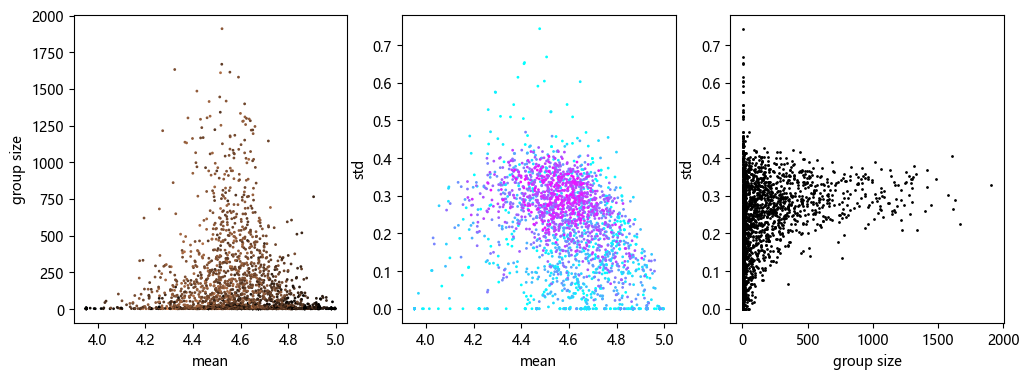

In [15]:
# Mean vs. group size
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(tg['mean'], tg['count'], s=1, c=tg['std'], cmap='copper')
# low std = black, high std = copper
plt.xlabel('mean')
plt.ylabel('group size')

# Mean vs. standard deviation
plt.subplot(1, 3, 2)
# small = cyan, large = magenta
plt.scatter(tg['mean'], tg['std'], s=1, c=np.log(tg['count']), cmap='cool')
plt.xlabel('mean')
plt.ylabel('std')

# Group size vs. standard deviation
plt.subplot(1, 3, 3)
plt.scatter(tg['count'], tg['std'], s=1, c='k', cmap='cool')
plt.xlabel('group size')
plt.ylabel('std')
plt.show()

There are many small groups and fewer large ones:

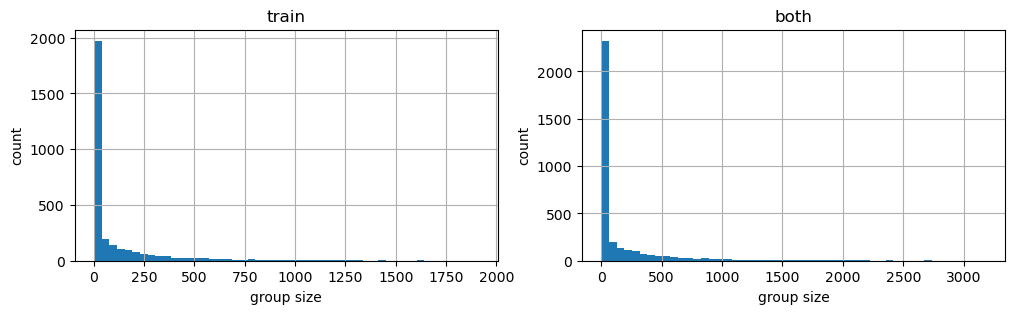

In [9]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('train')
tg['count'].hist(bins=50)
plt.xlabel('group size')
plt.ylabel('count')
plt.subplot(1, 2, 2)
plt.title('both')
both = pd.concat([train, test], axis=0)
bg = both.groupby(most_important_features).total_children.agg(['count']).sort_values('count')
bg['count'].hist(bins=50)
plt.xlabel('group size')
plt.ylabel('count')
plt.show()

**启示： 如果对训练样本进行分组，并只将3075个组提交给`fit()`函数，而不是360个单独的样本，可以节省大量的训练（和开发）时间。**当然，这个技巧只适用于那些在`fit()`函数中接受`sample_weight`参数的模型。

# EDA第二部分：`store_sqft'是一个分类特征

如果训练一个简单的随机森林模型，并绘制出最重要的特征--store_sqft的部分依赖关系，会看到一条奇怪的之字形线条，没有明显的趋势。还记得store_sqft只有20个独特的值吗？该特征只有20个独特的值，因为原始数据是从20家商店收集的。现在重要的见解是，目标并不取决于商店的大小! 商店的大小并不重要。目标取决于商店，但不取决于其规模。也可以把商店从1到20编号，或者把它们的位置作为特征，因为**商店（大小）是一个分类特征**。

如果接受store_sqft是一个分类特征，就应该把它作为一个分类特征来对待，例如，**尝试用OneHotEncoder或TargetEncoder对它进行编码**。

请注意，将商店作为一个分类特征，就无法对未见过的商店进行预测，但幸运的是，测试数据集的商店与训练商店是一样的。

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, LassoCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.inspection import PartialDependenceDisplay
from sklearn.cluster import AgglomerativeClustering

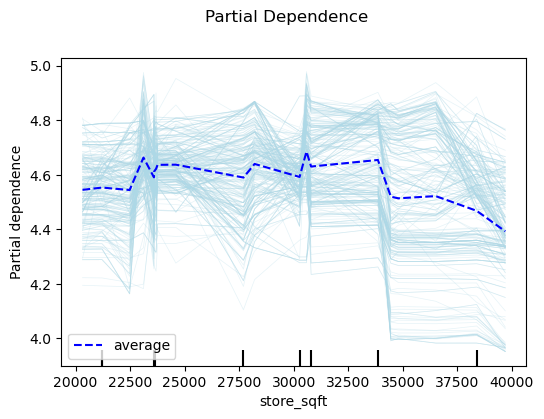

CPU times: total: 21.7 s
Wall time: 21.7 s


In [11]:
# %%time 是一个 Jupyter Notebook 的魔术命令，用于计算代码块的执行时间。
%%time
# 随机森林回归器模型的实例 参数，包括 bootstrap=False（禁用自助法）、max_features=5（每个决策树最大的特征数）、n_estimators=100（决策树的数量）等
model = RandomForestRegressor(bootstrap=False, max_features=5, n_estimators=100, min_weight_fraction_leaf=3/288268, random_state=1)
# 训练数据 train[most_important_features] 和目标变量 train['log_cost'] 对模型进行训练
model.fit(train[most_important_features], train['log_cost'])

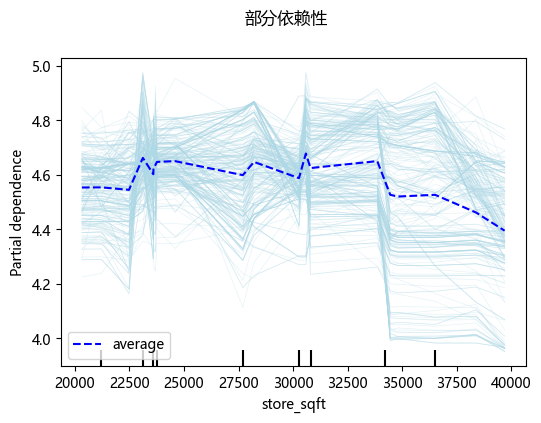

In [16]:
# 生成部分依赖关系的可视化
plt.figure(figsize=(6, 4))
plt.suptitle('部分依赖性', y=1.0)
PartialDependenceDisplay.from_estimator(model, train[most_important_features].sample(300),
                                        ['store_sqft'],
                                        percentiles=(0, 1),
                                        pd_line_kw={"color": "blue"},
                                        ice_lines_kw={"color": "lightblue"},
                                        kind='both',
                                        ax=plt.gca())
plt.show()

# 交叉验证

定义了一个函数`score_model()`,将用它来交叉验证每个模型。在这个函数中,可以看到训练样本是如何被分组以减少训练时间的。

In [17]:
def fit_model_grouped(model, train, features_used):
    """Group the duplicates in train and fit the model with the correct sample_weight"""
    train_grouped = train.groupby(features_used).log_cost.agg(['mean', 'count']).reset_index()
    X_tr = train_grouped[features_used]
    y_tr = train_grouped['mean']
    sample_weight_tr = train_grouped['count']
    if type(model) == Pipeline:
        sample_weight_name = model.steps[-1][0] + '__sample_weight'
    else:
        sample_weight_name = 'sample_weight'
    model.fit(X_tr, y_tr, **{sample_weight_name: sample_weight_tr})

def score_model(model, features_used, label=None, use_original=False):
    """Cross-validate a model"""
    start_time = datetime.datetime.now()
    score_list = []

    use_original = True

    oof = np.zeros_like(train[target], dtype=float)
    kf = KFold(shuffle=True, random_state=10)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        X_va = train.iloc[idx_va][features_used]
        y_va = train.iloc[idx_va][target]

        if use_original:
            fit_model_grouped(model, pd.concat([train.iloc[idx_tr], original], axis=0), features_used)
        else:
            fit_model_grouped(model, train.iloc[idx_tr], features_used)
            
        y_va_pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, y_va_pred, squared=False)
        print(f"Fold {fold}: rmse = {rmse:.4f}")
        oof[idx_va] = y_va_pred
        score_list.append(rmse)

    rmse = sum(score_list) / len(score_list)
    execution_time = datetime.datetime.now() - start_time
    print(f"{Fore.GREEN}{Style.BRIGHT}Average rmse: {rmse:.5f} {label if label is not None else ''}{Style.RESET_ALL}")
    if label is not None:
        global result_list
        result_list.append((label, model, features_used, rmse, oof, execution_time, use_original))
        

# 岭回归

从两个山脊回归模型开始。因为所有的特征都是分类的，所以对它们进行一热编码；因为目标取决于许多特征的相互作用，所以用`多项式特征`转化器创建相互作用。4度多项式比3度多项式的得分要高：

In [18]:
%%time
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first'), 
                                          ['total_children',
                                           'num_children_at_home', 'avg_cars_at home(approx).1',
                                           'store_sqft'])],
                                        remainder='passthrough'),
                      PolynomialFeatures(3, interaction_only=True, include_bias=False),
                      Ridge())
score_model(model, relevant_features, label=f'Onehot-Poly3-Ridge with unit_sales')

Fold 0: rmse = 0.2941
Fold 1: rmse = 0.2943
Fold 2: rmse = 0.2946
Fold 3: rmse = 0.2934
Fold 4: rmse = 0.2940
Average rmse: 0.29407 Onehot-Poly3-Ridge with unit_sales
CPU times: total: 1min 25s
Wall time: 17.6 s


In [19]:
%%time
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first'), 
                                          ['total_children',
                                           'num_children_at_home', 'avg_cars_at home(approx).1',
                                     
                                           'store_sqft'])],
                                        remainder='passthrough'),
                      PolynomialFeatures(4, interaction_only=True, include_bias=False),
                      Ridge())
score_model(model, most_important_features, label=f'Onehot-Poly4-Ridge')


Fold 0: rmse = 0.2930
Fold 1: rmse = 0.2934
Fold 2: rmse = 0.2938
Fold 3: rmse = 0.2925
Fold 4: rmse = 0.2931
Average rmse: 0.29316 Onehot-Poly4-Ridge
CPU times: total: 6min 44s
Wall time: 6min


# 树状模型

以三个随机森林开始树状模型部分。它们都使用相同的8个特征，但分类的store_sqft要么按原样使用，要么进行一热编码或目标编码：

In [20]:
%%time
score_model(RandomForestRegressor(bootstrap=False, max_features=5, n_estimators=400, min_weight_fraction_leaf=4.5/360336, random_state=44),
            most_important_features, label=f'RF')


Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2934
Fold 2: rmse = 0.2936
Fold 3: rmse = 0.2922
Fold 4: rmse = 0.2929
Average rmse: 0.29300 RF
CPU times: total: 21 s
Wall time: 21 s


In [22]:
%%time
score_model(make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first', sparse=bool('False')), ['store_sqft'])],
                                            remainder='passthrough'),
                          RandomForestRegressor(bootstrap=False, max_features=19, n_estimators=400,
                                                min_weight_fraction_leaf=4.5/360336, random_state=44)
                         ),
            most_important_features, label=f'Onehot-RF')

Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2934
Fold 2: rmse = 0.2937
Fold 3: rmse = 0.2923
Fold 4: rmse = 0.2930
Average rmse: 0.29305 Onehot-RF
CPU times: total: 24.7 s
Wall time: 24.7 s


In [ ]:
%%time
score_model(make_pipeline(TargetEncoder(verbose=30, cols=['store_sqft'], handle_unknown='error'),
                          RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=400,
                                                min_weight_fraction_leaf=4.5/360336, random_state=44)
                         ),
            most_important_features, label=f'Target-RF')


继续为不同的特征子集提供三个`ExtraTreesRegressor`：

In [ ]:
%%time
score_model(ExtraTreesRegressor(bootstrap=False, max_features=7, n_estimators=400, min_weight_fraction_leaf=4.5/360336, random_state=22),
            most_important_features, label=f'ET')


In [ ]:
%%time
score_model(ExtraTreesRegressor(bootstrap=False, max_features=7, n_estimators=400, min_weight_fraction_leaf=4.5/360336, random_state=22),
            most_important_features + ['unit_sales(in millions)'], label=f'ET with unit_sales')


In [ ]:
%%time
score_model(ExtraTreesRegressor(bootstrap=False, max_features=7, n_estimators=400, min_weight_fraction_leaf=4.5/360336, random_state=22),
            most_important_features + ['store_sales(in millions)'], label=f'ET with store_sales')


In [ ]:
%%time
score_model(make_pipeline(TargetEncoder(verbose=30, cols=['store_sqft'], handle_unknown='error'),
                          ExtraTreesRegressor(bootstrap=False, max_features=8, n_estimators=400,
                                              min_weight_fraction_leaf=4.5/360336, random_state=22)
                         ),
            most_important_features, label=f'Target-ET')


通过 `HistGradientBoostingRegressor`，可以将store_sqft作为原样使用，或者标记为分类特征或目标编码：

In [ ]:
%%time
score_model(HistGradientBoostingRegressor(max_iter=320, max_leaf_nodes=128, min_samples_leaf=2),
        most_important_features, label=f'HGB A')


In [ ]:
%%time
score_model(make_pipeline(ColumnTransformer([('oe', OrdinalEncoder(), 
                                              ['store_sqft'])],
                                            remainder='passthrough'),
                          HistGradientBoostingRegressor(max_iter=320, max_leaf_nodes=128, min_samples_leaf=2,
                                                        categorical_features=[0])),
            most_important_features, label=f'HGB B')


In [ ]:
%%time
score_model(make_pipeline(TargetEncoder(cols=['store_sqft'], handle_unknown='error'),
                          HistGradientBoostingRegressor(max_iter=320, max_leaf_nodes=128, min_samples_leaf=2)
                         ),
            most_important_features, label=f'Target-HGB')


为了完成笔记本的这一部分,用LightGBM、LightGBM-Dart和XGBoost两种变体来训练CatBoost：

In [ ]:
%%time
cb_params = {'n_estimators': 4000,
             'max_depth': 12,
             'learning_rate': 0.1,
             'verbose': False,
             'boost_from_average': True,
            }

score_model(catboost.CatBoostRegressor(**cb_params),
            most_important_features, f"CatBoost")

In [ ]:
%%time
cb_params = {'n_estimators': 1500,
             'max_depth': 12,
             'learning_rate': 0.1,
             'verbose': False,
             'boost_from_average': True,
            }

score_model(catboost.CatBoostRegressor(**cb_params),
            relevant_features, f"CatBoost with unit_sales")

In [ ]:
%%time
lgbm_params = {
    'learning_rate': 0.1,
    'n_estimators': 450,
    'num_leaves': 100,
    'min_child_samples': 1,
    'min_child_weight': 1e1,
    'categorical_feature': [most_important_features.index('store_sqft')],
    'random_state': 1
}
score_model(lightgbm.LGBMRegressor(**lgbm_params),
            most_important_features, f"LightGBM")

In [ ]:
%%time
dart_params = {'boosting_type': 'dart',
               'learning_rate': 0.3,
               'n_estimators': 400,
               'num_leaves': 200,
               'min_child_samples': 1,
               'min_child_weight': 10,
              }
score_model(lightgbm.LGBMRegressor(**dart_params),
            most_important_features, f"Dart")

In [ ]:
%%time
xgb_params = {'n_estimators': 280,
              'learning_rate': 0.05,
              'max_depth': 10,
              'subsample': 1.0,
              'colsample_bytree': 1.0,
              'tree_method': 'hist',
              'enable_categorical': True,
              'verbosity': 1,
              'min_child_weight': 3,
              'base_score': 4.6,
              'random_state': 1}

def cat_store_sqft(df):
    df = df.copy()
    df['store_sqft'] = df['store_sqft'].astype('category')
    return df

model = make_pipeline(FunctionTransformer(cat_store_sqft), xgboost.XGBRegressor(**xgb_params))
score_model(model, most_important_features, label=f"XGBoost")


# 神经网络的预处理

1. 该神经网络使用与大多数其他模型相同的八个特征。
2. 将所有的特征都视为分类的，并对其进行一次热编码。

In [ ]:
nn_features = most_important_features

preprocessor = make_pipeline(ColumnTransformer([('ohe',
                                                 OneHotEncoder(drop='first', sparse=False),
                                                 ['total_children', 'num_children_at_home',
                                                  'avg_cars_at home(approx).1', 'store_sqft'])],
                                               remainder='passthrough'
                                              ),
                             StandardScaler())

X = preprocessor.fit_transform(train[nn_features]).astype(float)
y = train[target]
X_te = preprocessor.transform(test[nn_features]).astype(float)
X_or = preprocessor.transform(original[nn_features]).astype(float)
y_or = original[target]

# 神经网络

该神经网络有一个顺序结构，四个隐藏层分别有256、128、64和64个神经元。在所有测试的激活函数中，relu给出了最好的结果。

In [ ]:
LR_START = 1/128
BATCH_SIZE = 1024

best_hp = keras_tuner.HyperParameters()
best_hp.values = {'reg1': 8e-6,
                  'reg2': 2e-6,
                  'units1': 256,
                  'units2': 128,
                  'units3': 64,
                  'units4': 64,
                 }
    
def my_model(hp=best_hp, n_inputs=X.shape[1]):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'relu'
    reg1 = hp.Float("reg1", min_value=1e-8, max_value=1e-4, sampling="log")
    reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-5, sampling="log")
    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(hp.Choice('units1', [64, 128, 256]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(inputs)
    x1 = Dense(hp.Choice('units2', [64, 128, 256]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x0)
    x2 = Dense(hp.Choice('units3', [32, 64, 128, 256]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x1)
    x3 = Dense(hp.Choice('units4', [32, 64, 128, 256]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x2)
    x = Dense(1, kernel_regularizer=tf.keras.regularizers.l2(reg2),
             )(x3)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
#                       metrics=[tf.keras.metrics.RootMeanSquaredError()],
                      loss=tf.keras.losses.MeanSquaredError(),
                      steps_per_execution=32
                     )
    
    return regressor

display(plot_model(my_model(), show_layer_names=False, show_shapes=True, dpi=72))


# 神经网络交叉验证

下面的循环对网络进行20次训练，并进行交叉验证。当训练没有进展时，会降低学习率，并应用早期停止。

In [ ]:
%%time
# Cross-validation
VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 1000
N_SPLITS = 10
N_REPEATS = 2

np.random.seed(2)
tf.random.set_seed(2)

start_time = datetime.datetime.now()
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))
kf = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
    model = None
    gc.collect()
    X_tr = X[idx_tr]
    y_tr = y[idx_tr]
    X_va = X[idx_va]
    y_va = y[idx_va]

    # Add the original data for training
    X_tr = np.vstack([X_tr, X_or])
    y_tr = pd.concat([y_tr, y_or])
    
    # Define the callbacks
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                           patience=4, verbose=VERBOSE)
    es = EarlyStopping(monitor="val_loss",
                       patience=12,
                       min_delta=0.00002,
                       verbose=0,
                       mode="min", 
                       restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    # Construct and compile the model
    model = my_model(best_hp, X_tr.shape[1])

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=(X_va, y_va), 
                        epochs=EPOCHS,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    del X_tr, y_tr
    test_preds += model.predict(X_te, batch_size=65536, verbose=VERBOSE).ravel()
    history = history.history
    callbacks, lr = None, None
    
    # Validate the model
    y_va_pred = model.predict(X_va, batch_size=len(X_va), verbose=VERBOSE).ravel()
    rmse = mean_squared_error(y_va, y_va_pred, squared=False)
    oof_preds[idx_va] += y_va_pred

    print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold}: {es.stopped_epoch:3} epochs,"
          f" rmse = {rmse:.4f}{Style.RESET_ALL}")
    del es, X_va #, y_va, y_va_pred
    score_list.append((None, rmse))

# Save oof and test predictions
assert np.isfinite(oof_preds).all()
oof_preds /= N_REPEATS
with open("oof_keras.pickle", 'wb') as f: pickle.dump(oof_preds, f)
keras_preds = test_preds / N_SPLITS / N_REPEATS
    
# Show overall score
score_df = pd.DataFrame(score_list, columns=['none', 'rmse'])
rmse = score_df['rmse'].mean()
print(f"{Fore.GREEN}{Style.BRIGHT}Average  rmse = {rmse:.5f}{Style.RESET_ALL}")
execution_time = datetime.datetime.now() - start_time
result_list.append(('Keras', None, nn_features, rmse, oof_preds, execution_time, True))


# 最终评价

试着分析一下模型zoo的多样性。可以计算出所有模型（预测值）之间的距离矩阵。矩阵的行是按分数排序的，也就是说，最好的模型在第一行，最差的在最后一行。最大的距离显然发生在最佳模型和最差模型之间。然而，有趣的是，Keras模型与最佳模型的距离（颜色较深）比它下面的模型更大。这意味着Keras模型给Ensemble带来了宝贵的多样性。

In [ ]:
# Create a dataframe of all results, ordered by score (best model comes first)
result_df = pd.DataFrame(result_list, columns=['label', 'model', 'features', 'rmse', 'oof', 'execution_time', 'use_original'])
result_df.drop_duplicates(subset='label', keep='last', inplace=True)
result_df = result_df[~result_df.label.str.contains('Mean')]
result_df.sort_values('rmse', inplace=True)
result_df.reset_index(drop=True, inplace=True)

# Display the distances between oof predictions
oof = np.column_stack(list(result_df.oof))
distances = euclidean_distances(oof.T, oof.T)
plt.figure(figsize=(10, 10))
plt.title('Distance between oof predictions')
sns.heatmap(distances, linewidth=0.1, fmt='.1f', 
            annot=True, annot_kws={'size': 8}, 
            cmap='YlOrRd',
            xticklabels=result_df.label,
            yticklabels=result_df.label,
           )
plt.show()

# Evaluate several unweighted blends and add them to the result list
r = result_df.set_index('label')
for i in range(2, len(r)+1):
    oof = np.column_stack(list(r.oof.iloc[:i]))
    oof = oof.mean(axis=1)
    rmse = mean_squared_error(train['log_cost'], oof, squared=False)
    result_list.append((f"Mean of {i}", None, None, rmse, oof, datetime.timedelta(), 'mean'))


现在使用岭回归来计算所有模型的加权混合的最佳权重。为了简单起见，不对回归进行交叉验证，而只是报告其训练分数。所显示的权重不是很可靠，但看到Keras和CatBoost的单位销售额的权重应该比其他模型高。

In [ ]:
# Weighted blend (ridge regression)
oof = np.column_stack(list(r.oof))
optimum_blend = Ridge(positive=True, tol=1e-6, alpha=100)
optimum_blend.fit(oof, train.log_cost.values)
optimum_oof = optimum_blend.predict(oof)
trmse = mean_squared_error(train.log_cost.values, optimum_oof, squared=False)
print(f'Ridge regression blend training rmse: {trmse:.5f}')
display(pd.Series(optimum_blend.coef_.round(2), r.index, name='weight'))
result_list.append((f"Optimum blend", None, None, trmse, optimum_oof, datetime.timedelta(), 'mean'))


树状图给出了对模型Zoo的另一种看法。树状图表示模型的分层聚类。相似的模型最终会出现在同一个集群中。可以很容易地识别出梯度提升模型的集群--它们的预测结果彼此相似。另一个聚类由使用额外的单位销售特征训练的模型组成：

In [ ]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and plot the dendrogram
    
    From https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    """

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, color_threshold=0.6, orientation='left', **kwargs)
    plt.xticks(plt.xticks()[0], (np.arccos(1 - plt.xticks()[0]) / math.pi * 180).round(0).astype(int))


oof = np.column_stack(list(r.oof))

# Setting distance_threshold=0 ensures we compute the full tree.
# We use a cosine similarity metric; other metrics are possible.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,
                                linkage='average', affinity='cosine')
model = model.fit(oof.T - oof.T.mean(axis=0))
plt.title("Hierarchical Clustering of Models")
plot_dendrogram(model, labels=r.index)
plt.show()

为了结束评估，在两个柱状图中显示了所有模型的得分和执行时间。柱状图显示了
- 所有18个单一模型、
- k在2到18之间的k个最佳单一模型的非加权混合、
- 加权混合。

一些观察结果：
1. 当加入第2个模型、第5个模型(随机森林)、第13个模型(Keras)和第15个模型(基于unit_sales特征的第一个模型)时，合集得分增加最多。
1. 集合体的多样性比梯度助推器的单一栽培要好。
1. 20个Keras的训练运行所花费的时间比其他所有模型加起来要多得多。
1. 最佳加权的混合模型并不比所有模型的简单平均值好多少。

In [ ]:
# Recreate the result dataframe
result_df = pd.DataFrame(result_list, columns=['label', 'model', 'features', 'rmse', 'oof', 'execution_time', 'use_original'])
result_df.drop_duplicates(subset='label', keep='last', inplace=True)
result_df.sort_values('rmse', inplace=True)
result_df.reset_index(drop=True, inplace=True)

# Plot the scores as horizontal bar chart
plt.figure(figsize=(12, len(result_df) * 0.3 + 1))
plt.suptitle('Final comparison', fontsize=20)
plt.subplot(1, 2, 1)
color = result_df.use_original.map({True: 'orange', False: 'yellow', 'mean': 'brown'})
bars = plt.barh(result_df.index, result_df.rmse, color=color)
plt.gca().bar_label(bars, fmt='%.5f')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.xlabel('RMSLE')
plt.xlim(0.292, 0.295)

# Plot the execution times as horizontal bar chart
plt.subplot(1, 2, 2)
bars = plt.barh(result_df.index, result_df.execution_time.dt.seconds, color='olive')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.xlabel('Execution time (s)')
plt.xlim(0, 1000)
plt.tight_layout(w_pad=1)
plt.show()

# 重新训练和提交

在完整的数据集上重新训练模型并创建提交文件。作为可信度的检查，绘制预测的直方图。如果这些直方图与其他人的直方图完全不同，就会知道代码在某处包含了一个错误。

In [ ]:
%%time
def submit(test_preds, path):
    """Write expm1(test_preds) to a csv file at path."""
    assert np.isfinite(test_preds).all()
    submission = pd.Series(np.expm1(test_preds), index=test.index, name='cost')
    submission.to_csv(path)
    with np.printoptions(precision=1, suppress=True):
        print(submission.values[:10])
    plt.figure(figsize=(10, 3))
    plt.title(path, fontsize=20)
    plt.hist(submission, bins=50)
    plt.show()

test_preds = np.zeros((len(test), ), dtype=float)
r['test_pred'] = None
for i in range(len(r)):
    print(f"Retraining {i:2} {r.index[i]} {'with original data' if r.iloc[i].use_original else ''}")
    if r.index[i] != 'Keras':
        features = r.iloc[i].features
        if r.iloc[i].use_original:
            fit_model_grouped(r.iloc[i].model, pd.concat([train, original], axis=0), features)
        else:
            fit_model_grouped(r.iloc[i].model, train, features)
        preds = r.iloc[i].model.predict(test[features])
    else:
        preds = keras_preds
    r.at[r.index[i], 'test_pred'] = preds
    test_preds += preds
    if i > 0:
        submit(test_preds / (i+1), f'submission_{i+1}.csv')
        
# Optimum blend
test_preds = np.column_stack(list(r.test_pred))
test_preds = optimum_blend.predict(test_preds)
submit(test_preds, 'submission_weighted.csv')
